In [70]:
import cv2
import mediapipe as mp
import numpy as np

mp_pose = mp.solutions.pose

def get_keypoints(image):
  # Convert the image to RGB format
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # Initialize the Pose estimator
  with mp_pose.Pose(static_image_mode = True, min_detection_confidence=0.5) as pose: # confidence determines speed
    # Process the image through the Pose estimator
    results = pose.process(image_rgb)

    # Initialize an empty list to store the keypoints
    keypoints = []

    # Iterate over the detected keypoints
    for landmark in results.pose_landmarks.landmark:
      # Get the coordinates of the landmark
      x, y, z = landmark.x, landmark.y, landmark.z
      # Append the keypoint to the list
      keypoints.append((x, y, z))
    
    return keypoints
  

# Example usage
image = cv2.imread('media/images/bad_back_squat.jpeg')
keypoints = get_keypoints(image)
print(keypoints) # prints 33 keypoints on the body

[(0.21799227595329285, 0.28535526990890503, -0.11752373725175858), (0.21004915237426758, 0.25710636377334595, -0.15419909358024597), (0.21260502934455872, 0.2538047134876251, -0.1542694866657257), (0.2152201235294342, 0.2502705752849579, -0.15450094640254974), (0.20759820938110352, 0.2588805556297302, -0.09504745155572891), (0.20850512385368347, 0.256666898727417, -0.09509889036417007), (0.20930525660514832, 0.2540760636329651, -0.09518732875585556), (0.2486581802368164, 0.22865307331085205, -0.2310483306646347), (0.24268221855163574, 0.23256650567054749, 0.03613309934735298), (0.24802449345588684, 0.28768566250801086, -0.14437046647071838), (0.24195346236228943, 0.28918182849884033, -0.06641887873411179), (0.38584601879119873, 0.27689167857170105, -0.31112203001976013), (0.37327778339385986, 0.27872467041015625, 0.20714879035949707), (0.5797209739685059, 0.26556769013404846, -0.6219700574874878), (0.5024067163467407, 0.3138308525085449, 0.43105486035346985), (0.41613274812698364, 0.25

I0000 00:00:1722109682.070717 36502948 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M2
W0000 00:00:1722109682.195665 36519957 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1722109682.203816 36519951 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/Users/advaithmalka/Library/Python/3.9/lib/python/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


In [71]:

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected poses to visualize.
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]

    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR)
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())
  
  return annotated_image

(-0.5, 1023.5, 680.5, -0.5)

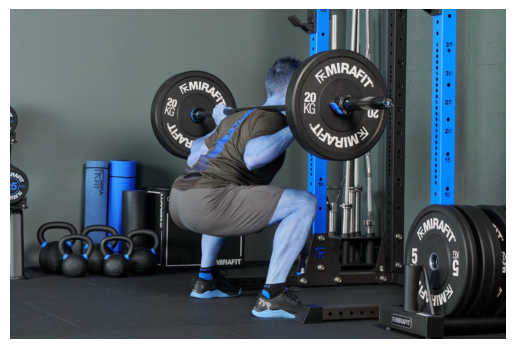

In [72]:
from matplotlib import pyplot as plt
img = cv2.imread("media/images/barbell_squat_perpendicular.jpg")
plt.imshow(img)
plt.axis(False)

In [73]:

# mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=numpy_frame_from_opencv)


In [74]:
def calculate_angle(a, b, c):
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)

    radians = np.arctan2(c[1] - b[1], c[0] - b[0]) - np.arctan2(a[1] - b[1], a[0] - b[0])
    angle = np.abs(radians * 180.0 / np.pi)

    if angle > 180.0:
        angle = 360.0 - angle

    return angle

def extract_angles(keypoints):
    angles = {}
    if keypoints is not None:
        angles['left_knee'] = calculate_angle(keypoints[23], keypoints[25], keypoints[27])
        angles['right_knee'] = calculate_angle(keypoints[24], keypoints[26], keypoints[28])
        angles['back'] = calculate_angle(keypoints[11], keypoints[23], keypoints[25])
        angles['head'] = calculate_angle(keypoints[0], keypoints[11], keypoints[23])
    return angles

def feedback(keypoints):
    # angles = extract_angles(keypoints)
    feedback = []
    
    # Knee angle feedback
    body_parts = mp_pose.PoseLandmark
    left_knee_parallelism = check_parallelism((keypoints[body_parts.LEFT_KNEE.value][0], keypoints[body_parts.LEFT_KNEE.value][1]), 
                  (keypoints[body_parts.LEFT_HIP.value][0], keypoints[body_parts.LEFT_HIP.value][1]))
    right_knee_parallelism = check_parallelism((keypoints[body_parts.RIGHT_KNEE.value][0], keypoints[body_parts.RIGHT_KNEE.value][1]), 
                  (keypoints[body_parts.RIGHT_HIP.value][0], keypoints[body_parts.RIGHT_HIP.value][1]))
    
    if left_knee_parallelism >= 10 or abs(left_knee_parallelism - 180) >= 10 or  right_knee_parallelism >= 10 or abs(right_knee_parallelism - 180) >= 10:
        feedback.append("Squat lower and try to keep your upper leg parallel to the ground.")         
    

    if not feedback:
        feedback.append("Great squat form!")

    return feedback

def check_parallelism(p1: tuple[float, float], p2:tuple[float, float]):
    v1= np.array([1,0]) # parallel ground vector
    v2= np.array([p2[0] - p1[0], p2[1] - p1[1]])

    if np.linalg.norm(v1) == 0 or np.linalg.norm(v2) == 0:
        return False  # vectors have zero length, can't be parallel
    
    # check if vectors are parallel using dot product 
    dot_product = np.dot(v1, v2)
    magnitude1 = np.linalg.norm(v1)
    magnitude2 = np.linalg.norm(v2)
    cosine_angle = dot_product / (magnitude1 * magnitude2)
    # Ensure the cosine value is in the valid range [-1, 1] to avoid numerical errors
    cosine_angle = np.clip(cosine_angle, -1.0, 1.0)
    angle = np.arccos(cosine_angle)
    angle_degrees = np.degrees(angle)
    return angle_degrees
        

In [75]:
# image = cv2.imread(IMG_PATH)
# keypoints = get_keypoints(image)
# angles = extract_angles(keypoints)
# plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))
# plt.axis(False)
# feedback(keypoints), angles
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
# IMG_PATH = "media/images/perfect_squat.jpg"
base_options = python.BaseOptions(model_asset_path="models/pose_landmarker_lite.task") # load light landmarker model

def print_result(result, output_image: mp.Image, timestamp_ms: int):
    print('pose landmarker result: {}'.format(result))
options = vision.PoseLandmarkerOptions(
  base_options=base_options,
  running_mode = vision.RunningMode.LIVE_STREAM,
  result_callback = print_result
)

detector = vision.PoseLandmarker.create_from_options(options)

# # STEP 3: Load the input image.
# image = mp.Image.create_from_file(IMG_PATH)

# # STEP 4: Detect pose landmarks from the input image.
# detection_result = detector.detect(image)

# # STEP 5: Process the detection result. In this case, visualize it.
# annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
# plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))
# plt.axis(False)

I0000 00:00:1722109682.446356 36502948 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M2
W0000 00:00:1722109682.525944 36519962 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1722109682.529091 36519968 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [76]:
cap = cv2.VideoCapture(0)  # Open webcam
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)
while cap.isOpened():
    ret, frame = cap.read()
    if not ret or not frame.any():
        print("Failed to capture image.")
        break
    keypoints = get_keypoints(frame)
    feedback = feedback(keypoints)
    print(feedback)
    
    # pose.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    annotated_frame = draw_landmarks_on_image(frame, detector.detect(frame))

    for line in feedback:
        cv2.putText(annotated_frame, line, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    cv2.imshow('Squat Analysis', annotated_frame)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

I0000 00:00:1722109682.605616 36502948 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M2
I0000 00:00:1722109682.630646 36502948 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M2
W0000 00:00:1722109682.693487 36519976 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1722109682.705940 36519976 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1722109682.708564 36519993 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1722109682.729318 36519996 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


['Squat lower and try to keep your upper leg parallel to the ground.']


ValueError: Please provide 'image_format' with 'data'.